In [31]:
import pandas as pd
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

**Load the yearly dataset**

In [33]:
yearly_data = pd.read_csv('/content/SN_y_tot_V2.0.csv', sep=';', header=None)
yearly_data.columns = ['Year', 'Sunspot Number', 'Std Dev', 'Observations', 'Indicator']
yearly_data_cleaned = yearly_data[yearly_data['Sunspot Number'] != -1]
yearly_data_cleaned['Date'] = yearly_data_cleaned['Year'].apply(lambda x: datetime(int(x), 1, 1))


**Restrict to the range starting from 1800**

In [34]:
yearly_data_cleaned = yearly_data_cleaned[
    (yearly_data_cleaned['Date'] >= datetime(1800, 1, 1)) &
    (yearly_data_cleaned['Date'] <= datetime(2024, 12, 31))
]


**Preparing data for prophet**

In [35]:
yearly_data_prepped = yearly_data_cleaned[['Date', 'Sunspot Number']].rename(columns={'Date': 'ds', 'Sunspot Number': 'y'})


**Defining and tuning the Prophet model**

In [36]:
model = Prophet(growth='flat', n_changepoints=10, changepoint_prior_scale=0.2)
model.add_seasonality(name='decade', period=10, fourier_order=3)
model.fit(yearly_data_prepped)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbygbr8u/qa6w9nvn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphbygbr8u/obczv4kw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96718', 'data', 'file=/tmp/tmphbygbr8u/qa6w9nvn.json', 'init=/tmp/tmphbygbr8u/obczv4kw.json', 'output', 'file=/tmp/tmphbygbr8u/prophet_model1x_40vk_/prophet_model-20241128201939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:19:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:19:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Make predictions for 1, 10, and 20 years into the future**

In [37]:
future = model.make_future_dataframe(periods=20, freq='Y')  # 'Y' is for yearly frequency
forecast = model.predict(future)

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


**Plot the forecast**

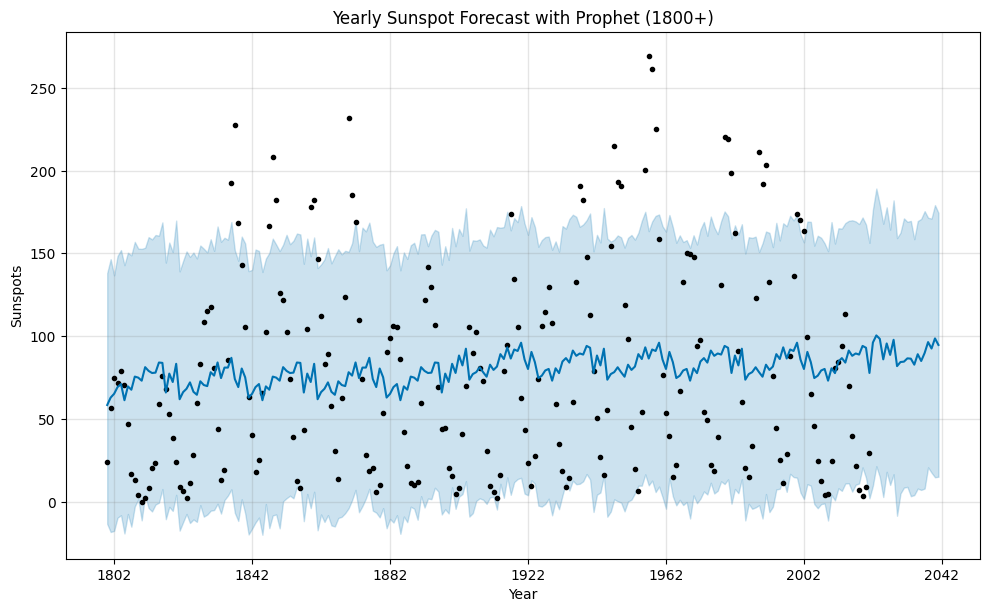

In [38]:
model.plot(forecast)
plt.title("Yearly Sunspot Forecast with Prophet (1800+)")
plt.xlabel("Year")
plt.ylabel("Sunspots")
plt.savefig("yearly_forecast_plot_1800.png")
plt.show()

**Extract predicted intervals for 1, 10, and 20 years**

In [39]:
predicted_intervals = forecast.iloc[[-1, -10, -20]][['ds', 'yhat']]

**Evaluating the model**

In [40]:
history = forecast[forecast['ds'] <= yearly_data_prepped['ds'].max()]
mae = mean_absolute_error(yearly_data_prepped['y'], history['yhat'])
mape = np.mean(np.abs((yearly_data_prepped['y'] - history['yhat']) / yearly_data_prepped['y'])) * 100
r2 = r2_score(yearly_data_prepped['y'], history['yhat'])

**Save the forecast**

In [41]:
forecast.to_csv('yearly_forecast_1800.csv', index=False)

**Print metrics and predictions**

In [42]:
print("Yearly Forecast Metrics (1800+):")
print(f"MAE: {mae}, MAPE: {mape}, R2: {r2}")
print("\nPredicted Sunspots for specified intervals:")
print(predicted_intervals)

Yearly Forecast Metrics (1800+):
MAE: 51.50975035305899, MAPE: inf, R2: 0.017831910862557532

Predicted Sunspots for specified intervals:
            ds       yhat
241 2040-12-31  94.759034
232 2031-12-31  86.672673
222 2021-12-31  96.225536
